# GL / GM work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

## Prepare the data

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs

In [3]:
yp = YAMLParser()

In [4]:
# read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
CPU times: user 4.37 s, sys: 664 ms, total: 5.04 s
Wall time: 35 s


## Average data over last 2000 days

In [5]:
for exp, v in exps_param.items():
        ds = v['ds']
        dst = ds.mean(dim='time', keep_attrs=True)
        v['dst'] = dst

## Plotting

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [7]:
import cartopy.crs as ccrs

In [8]:
exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']['label'] = '1/2$^\circ$ GL 800'

In [8]:
exp_GM = 'nw2_0.5deg_N15_KHTH800'
exp_GL = 'nw2_0.5deg_N15_KHGL800_hbbl5'

with ProgressBar():
    exps_param[exp_GM]['dst']['GMwork'].load()
    exps_param[exp_GL]['dst']['GLwork'].load()

[########################################] | 100% Completed | 11.5s
[########################################] | 100% Completed | 20.6s


In [9]:
import matplotlib as mpl
cmap = mpl.cm.PuBuGn_r
cmap.set_bad('gray')

In [10]:
from matplotlib.colors import ListedColormap

newcmap = mpl.colormaps['RdBu_r']
newcmap = newcmap(np.linspace(0, 1, 15))
newcmap = ListedColormap(newcmap)
newcmap.set_bad(color='gray') 

In [11]:
newcolors = np.ones((16, 3))
newcolors[:7, :] = newcmap.colors[:7, :3]
newcolors[9:, :] = newcmap.colors[8:, :3]

In [12]:
newcmp = ListedColormap(newcolors)

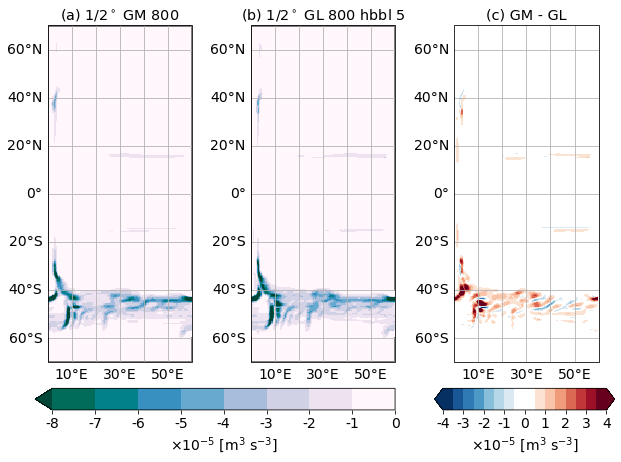

In [13]:
extent = [0, 60, -70, 70]
vmax = 0.00008

fig, axs = plt.subplots(1, 3, figsize=(10, 6), subplot_kw={'projection':ccrs.PlateCarree()})

dst_GM = exps_param[exp_GM]['dst']
dst_GL = exps_param[exp_GL]['dst']

st = exps_param[exp_GM]['st']
    
GMwork = dst_GM['GMwork'] / 1000
GLwork = dst_GL['GLwork'].sum(dim='zl')
diff = (GMwork - GLwork) 

ax = axs[0]
GMwork.where(st.wet).plot(
        ax=ax, 
        vmax=0, vmin=-vmax, cmap=cmap,
        levels=9,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
)
ax.set_title('(a) %s' %exps_param[exp_GM]['label'])

ax = axs[1]
p = GLwork.where(st.wet).plot(
        ax=ax, 
        vmax=0, vmin=-vmax, cmap=cmap,
        levels=9,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
)
ax.set_title('(b) %s' %exps_param[exp_GL]['label'])

ax = axs[2]
d = diff.where(st.wet).plot.contourf(
        cmap=newcmp,
        ax=ax,
        vmin=-vmax/2,
        vmax=vmax/2,
        levels=17,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
        )
ax.set_title('(c) GM - GL')


for ax in axs:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

# colorbars
fig.subplots_adjust(left=0.1, bottom=0.1)

ticks = 0.00001 * np.arange(-8, 0.1, 1)
xticklabels = ['-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0']
cax1 = fig.add_axes([0.1, -0.01, 0.5, 0.05])
cb1 = fig.colorbar(p, cax=cax1, orientation='horizontal', extend='min', ticks=ticks)
cb1.ax.tick_params(labelsize=14)
cb1.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]', size=14)
cb1.ax.set_xticklabels(xticklabels)

ticks = 0.00001 * np.arange(-4, 4.1, 1)
xticklabels = ['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4']

cax2 = fig.add_axes([0.655, -0.01, 0.25, 0.05])
cb2 = fig.colorbar(d, cax=cax2, orientation='horizontal', extend='both', ticks=ticks)
cb2.ax.tick_params(labelsize=14)
cb2.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]', size=14)
cb2.ax.set_xticklabels(xticklabels)

figname = '/glade/u/home/noraloose/GL90paper/figures/GMvsGLwork_0.5deg.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)